<a href="https://colab.research.google.com/github/lesi-nedo/ISPR_assignments/blob/main/assignment_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center" ><b> <font face="Rage" size=7 >Prediction of the Benzene</font></b></div>

<div align="center" ><b> <font face="Rage" size=5 >Assignment 3</font></b></div>
<div align="center" ><b> <font face="Rage" size=4 >Oleksiy Nedobiychuk</font></b></div>


### Setup and Download or load the dataset
Since we want to be able to predict the Benzene values, thus for me make sense to discard all the values -200 that are consider nan in the C6H6 column
.

In [ ]:
import os
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import zipfile as zf
from io import StringIO

try:
  from google.colab import drive
  drive.mount('/content/drive')
  local_path = "/content/drive/MyDrive/ISPR/"
except ModuleNotFoundError:
  local_path = "/home/lesi-nedo/Desktop/master/second-semester/ISPR/ass"

# Define the URL for the data
url_dataset = "https://archive.ics.uci.edu/static/public/360/air+quality.zip"

file_name_down = "AirQualityUCI.csv"
file_name = "air_quality.csv"
file_name_zip = "air_quality.zip"
abs_file_name = os.path.join(local_path, file_name)
abs_file_name_zip = os.path.join(local_path, file_name_zip)
zipped = True

def check_or_download(url, abs_file_name, abs_file_name_zip):
    global zipped
    path = None
    if not os.path.exists(abs_file_name):
        if os.path.exists(abs_file_name_zip):
            os.remove(abs_file_name_zip)
        print("Downloading file")
        path, _ = urlretrieve(url, abs_file_name_zip)
    else:
        path = abs_file_name
        zipped = False
        print("File already downloaded")
    return path

path_dataset = check_or_download(url_dataset, abs_file_name=abs_file_name, abs_file_name_zip=abs_file_name_zip)
if zipped:
    with zf.ZipFile(path_dataset, "r") as f_in:
        print(f_in.namelist())
        with f_in.open(file_name_down, "r") as f_out:
            dataset_csv = StringIO(str(f_out.read(), "utf-8"))

            dataset = pd.read_csv(dataset_csv, delimiter=";", date_format="%d/%m/%Y", parse_dates=[",,,,,Date"])
            dataset.to_csv(abs_file_name)

else:
    dataset = pd.read_csv(abs_file_name, delimiter=";", date_format="%d/%m/%Y", parse_dates=[",,,,,Date"])
dataset = dataset.filter(regex="Date|C6H6*|PT08*")
dataset.rename(columns={",,,,,Date": "Date"}, inplace=True)
dataset['C6H6(GT)'] = dataset['C6H6(GT)'].astype(str)
dataset['C6H6(GT)'] = dataset['C6H6(GT)'].apply(lambda x: x.replace(",", "."))
dataset['C6H6(GT)'] = dataset['C6H6(GT)'].astype(np.double)
dataset['C6H6(GT)'] = dataset['C6H6(GT)'].replace(to_replace=-200, value=np.nan)
dataset.dropna(subset=["Date", "C6H6(GT)"], inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset[:5]



File already downloaded


,Date,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,2004-03-10,1360.0,11.9,1046.0,1056.0,1692.0,1268.0
1,2004-03-10,1292.0,9.4,955.0,1174.0,1559.0,972.0
2,2004-03-10,1402.0,9.0,939.0,1140.0,1555.0,1074.0
3,2004-03-10,1376.0,9.2,948.0,1092.0,1584.0,1203.0
4,2004-03-10,1272.0,6.5,836.0,1205.0,1490.0,1110.0


### Data visualization


<Axes: >

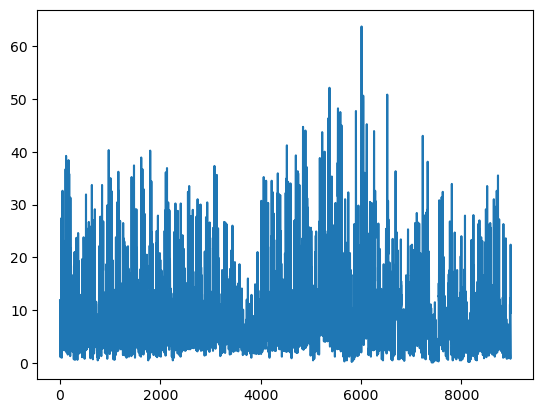

In [ ]:
dataset['C6H6(GT)'].plot()

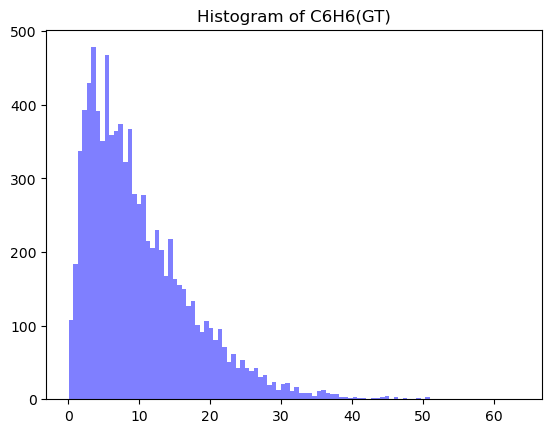

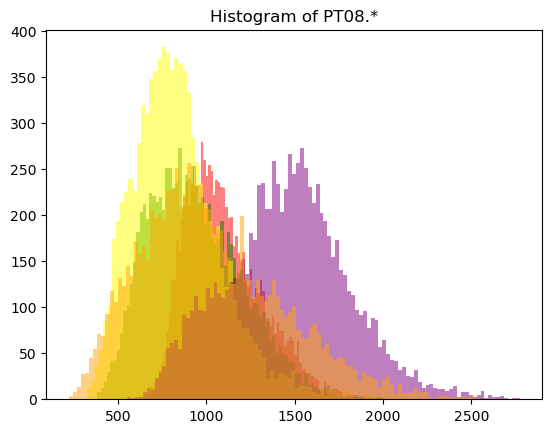

In [ ]:
import matplotlib.pyplot as plt

plt.hist(dataset["C6H6(GT)"], bins=100, color="blue", alpha=0.5)
plt.title("Histogram of C6H6(GT)")
plt.show()
plt.close()
plt.hist(dataset["PT08.S1(CO)"], bins=100, color="red", alpha=0.5)
plt.hist(dataset["PT08.S2(NMHC)"], bins=100, color="green", alpha=0.5)
plt.hist(dataset["PT08.S3(NOx)"], bins=100, color="yellow", alpha=0.5)
plt.hist(dataset["PT08.S4(NO2)"], bins=100, color="purple", alpha=0.5)
plt.hist(dataset["PT08.S5(O3)"], bins=100, color="orange", alpha=0.5)
plt.title("Histogram of PT08.*")
plt.show()



### Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import math
import torch.nn.functional as F
from tqdm import tqdm
import sys, time
from scipy.stats import pearsonr
from sklearn.metrics import  r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# inter = dataset.drop(columns=["Date"])
# min_scale = inter.to_numpy().min()
# max_scale = inter.to_numpy().max()
# inter = (inter - min_scale) / (max_scale - min_scale)
# X = inter.drop(columns=["C6H6(GT)"])
# y = inter[["C6H6(GT)"]]

X = dataset.drop(columns=["Date", "C6H6(GT)"])
y = dataset[["C6H6(GT)"]]

batch_size = 64
epochs = 100
scaler_PT08 = MinMaxScaler()
scaler_c6h6 = MinMaxScaler(feature_range=(0, 1))

y = pd.DataFrame(scaler_c6h6.fit_transform(y.values.reshape(-1, 1)), columns=["C6H6(GT)"])
X = pd.DataFrame(scaler_PT08.fit_transform(X), columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_eval.reset_index(drop=True, inplace=True)
y_eval.reset_index(drop=True, inplace=True)

X_eval[:5]

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3)
0,0.549892,0.474058,0.066074,0.428507,0.634666
1,0.633884,0.569088,0.057179,0.640288,0.621633
2,0.430725,0.466958,0.156290,0.628147,0.354040
3,0.147882,0.206991,0.343922,0.284622,0.184622
4,0.389806,0.336974,0.127912,0.270234,0.460035


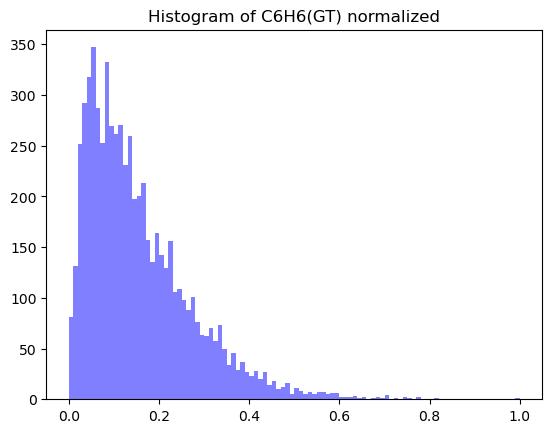

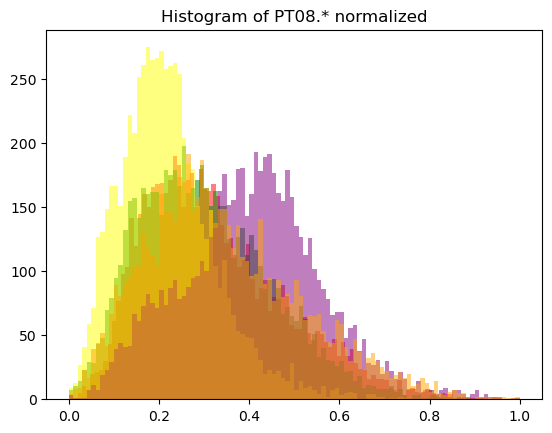

In [ ]:
plt.hist(y_train["C6H6(GT)"], bins=100, color="blue", alpha=0.5)
plt.title("Histogram of C6H6(GT) normalized")
plt.show()
plt.close()
plt.hist(X_train["PT08.S1(CO)"], bins=100, color="red", alpha=0.5)
plt.hist(X_train["PT08.S2(NMHC)"], bins=100, color="green", alpha=0.5)
plt.hist(X_train["PT08.S3(NOx)"], bins=100, color="yellow", alpha=0.5)
plt.hist(X_train["PT08.S4(NO2)"], bins=100, color="purple", alpha=0.5)
plt.hist(X_train["PT08.S5(O3)"], bins=100, color="orange", alpha=0.5)
plt.title("Histogram of PT08.* normalized")
plt.show()
plt.close()

### Association/Correlation test


In [ ]:
print(f"Correlation between 'PT08.S1(CO)' column and C6H6(GT): {pearsonr(X_train['PT08.S1(CO)'], y_train['C6H6(GT)'])[0]}")
print(f"Correlation between 'PT08.S2(NMHC)' column and C6H6(GT): {pearsonr(X_train['PT08.S2(NMHC)'], y_train['C6H6(GT)'])[0]}")
print(f"Correlation between 'PT08.S3(NOx)' column and C6H6(GT): {pearsonr(X_train['PT08.S3(NOx)'], y_train['C6H6(GT)'])[0]}")
print(f"Correlation between 'PT08.S4(NO2)' column and C6H6(GT): {pearsonr(X_train['PT08.S4(NO2)'], y_train['C6H6(GT)'])[0]}")
print(f"Correlation between 'PT08.S5(O3)' column and C6H6(GT): {pearsonr(X_train['PT08.S5(O3)'], y_train['C6H6(GT)'])[0]}")
print(f"Correlation between the average of PT08* columns and C6H6(GT): {pearsonr(X_train.mean(axis=1), y_train['C6H6(GT)'])[0]}")


Correlation between 'PT08.S1(CO)' column and C6H6(GT): 0.8841018211044929
Correlation between 'PT08.S2(NMHC)' column and C6H6(GT): 0.9817115478331292
Correlation between 'PT08.S3(NOx)' column and C6H6(GT): -0.7312937179591905
Correlation between 'PT08.S4(NO2)' column and C6H6(GT): 0.7631782605555761
Correlation between 'PT08.S5(O3)' column and C6H6(GT): 0.863810758183598
Correlation between the average of PT08* columns and C6H6(GT): 0.9473479995042394


It's evident that each column is highly correlated with the Benzene value, and even more so with the average

### Creation of test set, eval set and test set

In [ ]:

trainset = list(zip(X_train.values, y_train.values))
evalset = list(zip(X_eval.values, y_eval.values))
testset = list(zip(X_test.values, y_test.values))


trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last = True)

evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle = True, drop_last = True)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, drop_last = True)

## Phased LSTM model
This code was taken from [here](https://github.com/dannyneil/pytorch_plstm) and adjusted to today reality.

While searching for an appropriate model, I found this one particularly intriguing. According to the paper ([this]( https://arxiv.org/pdf/1610.09513)), it has the potential to outperform traditional LSTM models in this task.


In [ ]:


OFF_SLOPE=1e-6

# function to extract grad
def set_grad(var):
    def hook(grad):
        var.grad = grad
    return hook

class GradMod(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input, other):
        """
        In the forward pass we receive a Tensor containing the input and return a
        Tensor containing the output. You can cache arbitrary Tensors for use in the
        backward pass using the save_for_backward method.
        """
        result = torch.fmod(input, other)
        ctx.save_for_backward(input, other)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        x, y = ctx.saved_tensors
        return grad_output * 1, grad_output * torch.neg(torch.floor_divide(x, y))

class PLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.Periods = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.Shifts = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.On_End = nn.Parameter(torch.Tensor(hidden_sz, 1))
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
        # Phased LSTM
        # -----------------------------------------------------
        nn.init.constant_(self.On_End, 0.3) # Set to be 5% "open"
        nn.init.uniform_(self.Shifts, 0, 100) # Have a wide spread of shifts
        # Uniformly distribute periods in log space between exp(1, 3)
        self.Periods.data.copy_(torch.exp((3 - 1) *
            torch.rand(self.Periods.shape) + 1))
        # -----------------------------------------------------

    def forward(self, x, ts,
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device).type(torch.double),
                        torch.zeros(bs, self.hidden_size).to(x.device).type(torch.double))
        else:
            h_t, c_t = init_states



        # PHASED LSTM
        # -----------------------------------------------------
        # Precalculate some useful vars
        shift_broadcast = self.Shifts.view(1, -1)
        period_broadcast = abs(self.Periods.view(1, -1))
        on_mid_broadcast = abs(self.On_End.view(1, -1)) * 0.5 * period_broadcast
        on_end_broadcast = abs(self.On_End.view(1, -1)) * period_broadcast

        def calc_time_gate(time_input_n):
            # Broadcast the time across all units
            t_broadcast = time_input_n.unsqueeze(-1)
            # Get the time within the period
            in_cycle_time = GradMod.apply(t_broadcast + shift_broadcast, period_broadcast)

            # Find the phase
            is_up_phase = torch.le(in_cycle_time, on_mid_broadcast)
            is_down_phase = torch.gt(in_cycle_time, on_mid_broadcast)*torch.le(in_cycle_time, on_end_broadcast)


            # Set the mask
            sleep_wake_mask = torch.where(is_up_phase, in_cycle_time/on_mid_broadcast,
                                torch.where(is_down_phase,
                                    (on_end_broadcast-in_cycle_time)/on_mid_broadcast,
                                        OFF_SLOPE*(in_cycle_time/period_broadcast)))
            return sleep_wake_mask
        # -----------------------------------------------------
        HS = self.hidden_size
        for t in range(seq_sz):
            old_c_t = c_t
            old_h_t = h_t
            x_t = x[:, t, :]
            t_t = ts[:, t]

            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias

            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

            # PHASED LSTM
            # -----------------------------------------------------
            # Get time gate openness
            sleep_wake_mask = calc_time_gate(t_t)
            # Sleep if off, otherwise stay a bit on
            c_t = sleep_wake_mask*c_t + (1. - sleep_wake_mask)*old_c_t
            h_t = sleep_wake_mask*h_t + (1. - sleep_wake_mask)*old_h_t
            # -----------------------------------------------------
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)


class PLSTMModel(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz_linear=1):
        super().__init__()
        self.hidden_sz = hidden_sz
        self.plstm = PLSTM(input_sz, hidden_sz)
        #self.batchnorm = nn.BatchNorm1d(hidden_sz)
        #self.sigm = nn.Sigmoid()
        self.fc = nn.Linear(hidden_sz, output_sz_linear)




    def forward(self, values, times):
        values = values.reshape(values.shape[0], 1, -1).type(dtype=torch.double)
        plstm_out,_ = self.plstm(values, times)
        #sigm_out = self.sigm(plstm_out)
        #norm_out = self.batchnorm(sigm_out)

        out_lin = self.fc(plstm_out[:, -1, :])

        return out_lin




### Train and Test loops

In [ ]:
max_duration = 100
min_duration = 10
log_interval = 100

def get_time(max_duration, min_duration, batch_size):
    duration = torch.rand(batch_size)*(max_duration-min_duration)+min_duration
    start = torch.rand(batch_size)*(max_duration-min_duration)
    return duration, start

def validate(model, device, evalloader, criterion=F.huber_loss, plstm=True):
    model.eval()
    val_loss = 0
    batches_per_epoch = len(evalloader)
    with torch.no_grad():
        for batch_idx, batches in enumerate(evalloader):
            X_batch, y_batch = batches

            if plstm:
                duration, start = get_time(max_duration, min_duration, batches_per_epoch)
                sample_res = duration[batch_idx]/X_batch.shape[1]
                time_g = np.full((batch_size, X_batch.shape[1]), torch.arange(start[batch_idx], start[batch_idx]+duration[batch_idx], step=sample_res, device=device)[:5])
                y_pred = model(X_batch, torch.tensor(time_g, device=device, dtype=torch.double))
            else:
                y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch)
    model.train()
    return val_loss/batches_per_epoch

def train(model, device, trainloader, evalloader, optimizer, criterion=F.huber_loss, epochs=100, clip_value=1.0, plstm=True):
    model.train()
    losses = []
    val_losses = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.5, patience=10, threshold=0.001, threshold_mode='abs')

    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

    batches_per_epoch = len(trainloader)

    for epoch in tqdm(range(epochs), file=sys.stdout):
        loss_per_epoch = 0
        val_loss_per_epoch = 0
        for batch_idx,batches in enumerate(trainloader):
            X_batch, y_batch = batches


            if plstm:
                duration, start = get_time(max_duration, min_duration, batches_per_epoch)
                sample_res = duration[batch_idx]/X_batch.shape[1]
                time_g = np.full((batch_size, X_batch.shape[1]), torch.arange(start[batch_idx], start[batch_idx]+duration[batch_idx], step=sample_res, device=device)[:5])
                y_pred = model(X_batch,
                           torch.tensor(time_g, device=device, dtype=torch.double))
            else:
                y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss_per_epoch += loss.item()


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        val_loss = validate(model, device, evalloader, criterion, plstm=plstm)
        val_losses.append(val_loss.item())
        losses.append(loss.item())
        scheduler.step(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)


        time.sleep(0.5)
        print(f" -------- Train Epoch: {epoch}\t Train Loss: {loss_per_epoch/batches_per_epoch:.6f} Val loss: {val_loss.item()} -- Learning Rate: {optimizer.param_groups[-1]['lr']}",  end='\n', flush=True)
    return (losses, val_losses)

def test (model, device, testloader, criterion=F.huber_loss, plstm=True):
    model.eval()
    test_loss = 0
    all_preds = []
    total = 0
    batches_per_epoch = len(testloader)

    with torch.no_grad():
        for batch_idx, batches in enumerate(testloader):
            X_batch, y_batch = batches

            if plstm:
                duration, start = get_time(max_duration, min_duration, batches_per_epoch)
                sample_res = duration[batch_idx]/X_batch.shape[1]
                time_g = np.full((batch_size, X_batch.shape[1]), torch.arange(start[batch_idx], start[batch_idx]+duration[batch_idx], step=sample_res, device=device)[:5])
                y_pred = model(X_batch.reshape(X_batch.shape[0], -1, 1).type(dtype=torch.double), torch.tensor(time_g, device=device, dtype=torch.double))
            else:
                y_pred = model(X_batch)
            test_loss += criterion(y_pred, y_batch)
            total += 1
            all_preds.append(torch.flatten(y_pred).unsqueeze(0))


        print(f"Test set: Average loss: {test_loss/total:.6f}--- Total: {total}")
    return all_preds

### Training


In [ ]:
model = PLSTMModel(input_sz=X_train.shape[1], hidden_sz=32, output_sz_linear=1)
model.to(torch.double)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-7)
losses = train(model, device, trainloader, evalloader, optimizer, criterion=F.smooth_l1_loss, epochs=100, clip_value=1.0)



100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


### Loss Visualization

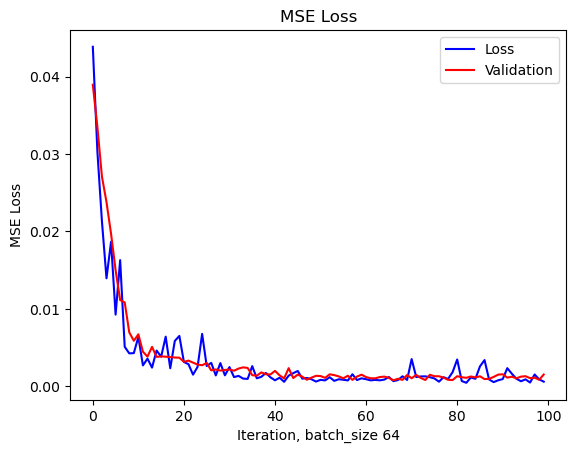

In [ ]:
test_losses, eval_losses = losses
plt.title("MSE Loss")
plt.xlabel("Iteration, batch_size " + str(batch_size))
plt.ylabel("MSE Loss")
plt.plot(test_losses, label="Loss", color="blue")
plt.plot(eval_losses, label="Validation", color="red")
plt.legend()
plt.show()
plt.close()

### Testing the average loss on test set
The plot compares the predicted C6H6 value and the actual

Test set: Average loss: 0.001217--- Total: 28
Correlation: -0.028174086885934032
R2 Score: -0.8695147008733402
Mean Squared Error: 105.31995924483324
Mean Absolute Error: 7.91439110033001


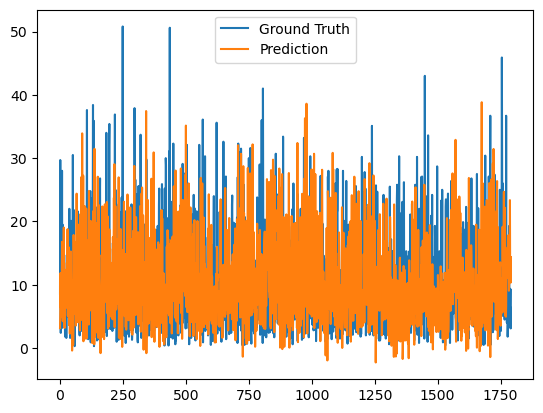

In [ ]:
y_pred_plsm = test(model, device, testloader, criterion=F.smooth_l1_loss)
y_pred_plsm = scaler_c6h6.inverse_transform(torch.flatten(torch.cat(tuple(e for e in y_pred_plsm), dim=1)).numpy().reshape(-1, 1)).flatten()
y_ground = scaler_c6h6.inverse_transform(y_test.values[:len(y_pred_plsm)].reshape(-1, 1)).flatten()
print(f"Correlation: {pearsonr(y_ground, y_pred_plsm)[0]}")
print(f"R2 Score: {r2_score(y_ground, y_pred_plsm)}")
print(f"Mean Squared Error: {mean_squared_error(y_ground, y_pred_plsm)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_ground, y_pred_plsm)}")
plt.plot(y_ground, label="Ground Truth")
plt.plot(y_pred_plsm, label="Prediction")
plt.legend()
plt.show()
plt.close()


Since I couldn't find a recent implementation of PLSTM in any major library, I decided to use one I found on GitHub from three years ago. I had to modify a few things to make it suitable for my task. As I'm still inexperienced in this field, I decided to also train a traditional LSTM using PyTorch to ensure I wasn't making any major mistakes and to compare the results. Also, the correlation and R2 scores are quite poor, so I'm interested in observing how the traditional model will perform.

### Traditional LSTM
Since I'm not happy with the results, I decided to train a standard LSTM.

In [ ]:
from torch.autograd import Variable

class MyLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, num_layers=1, output_sz_linear=1):
        super(MyLSTM, self).__init__()
        self.hidden_sz = hidden_sz
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_sz, hidden_size=hidden_sz, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_sz, output_sz_linear)
        # self.batchnorm = nn.BatchNorm1d(hidden_sz)
        # self.relu = nn.ReLU()


    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(self.hparams.nb_lstm_layers, self.batch_size, self.nb_lstm_units)
        hidden_b = torch.randn(self.hparams.nb_lstm_layers, self.batch_size, self.nb_lstm_units)

        if self.hparams.on_gpu:
            hidden_a = hidden_a.cuda()
            hidden_b = hidden_b.cuda()

        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)


    def forward(self, values):
        values = values.reshape(values.shape[0], 1, -1).type(dtype=torch.double)
        h_0 = Variable(torch.randn(self.num_layers, values.size(0), self.hidden_sz).type(torch.double))
        c_0 = Variable(torch.randn(self.num_layers, values.size(0), self.hidden_sz).type(torch.double))

        lstm_out, _ = self.lstm(values, (h_0, c_0))
        # batch_out = self.batchnorm(lstm_out[:, -1, :])
        # relu_out = self.relu(batch_out)
        linear_out = self.fc(lstm_out)

        return linear_out[:, -1, :]

### Training

In [ ]:

model1 = MyLSTM(input_sz=X_train.shape[1], hidden_sz=32, output_sz_linear=1)
model1.to(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
optimizer = torch.optim.Adam(model1.parameters(),  lr=2e-4, weight_decay=1e-7)
losses1 = train(model1, device, trainloader, evalloader, optimizer, criterion=F.smooth_l1_loss, epochs=100, plstm=False, clip_value=2.0)



100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


### Comparing the training loss and evaluation loss

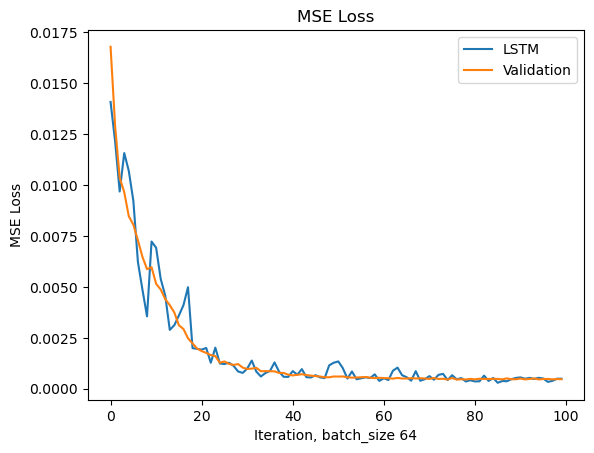

In [ ]:
train_losses, eval_losses = losses1
plt.title("MSE Loss")
plt.xlabel("Iteration, batch_size " + str(batch_size))
plt.ylabel("MSE Loss")
plt.plot(train_losses, label="LSTM")
plt.plot(eval_losses, label="Validation")
plt.legend()
plt.show()
plt.close()

### Comparing predicted and actual vector
The performance on predicting the values is still very poor, which is quite disappointing.

Test set: Average loss: 0.001026--- Total: 28
Shape of y_pred: (1792,) -- Shape of y_ground: (1792,)
Correlation: -0.00445896116080341
R2 Score: -0.9401735613000315
Mean Squared Error: 109.30055821896758
Mean Absolute Error: 7.968244807710113


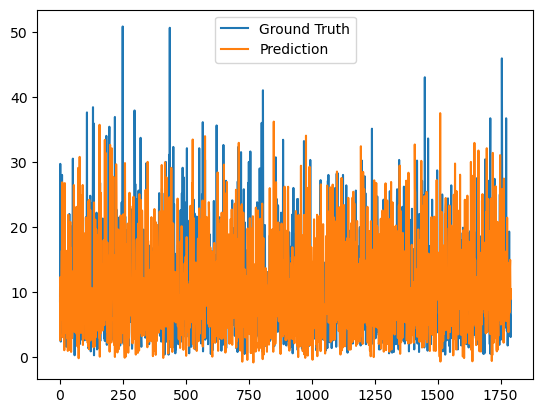

In [ ]:
y_pred_lsm = test(model1, device, testloader, criterion=F.mse_loss, plstm=False)
y_pred_lsm = torch.flatten(torch.cat(tuple(e for e in y_pred_lsm), dim=1)).numpy()
y_pred_lsm = scaler_c6h6.inverse_transform(y_pred_lsm.reshape(-1, 1)).flatten()
y_ground = y_test.values[:len(y_pred_lsm)].squeeze()
y_ground = scaler_c6h6.inverse_transform(y_test.values[:len(y_pred_lsm)].reshape(-1, 1)).flatten()
# y_pred_lsm = y_pred_lsm * (max_scale - min_scale) + min_scale
# y_ground = y_ground * (max_scale - min_scale) + min_scale
print(f"Shape of y_pred: {y_pred_lsm.shape} -- Shape of y_ground: {y_ground.shape}")
print(f"Correlation: {pearsonr(y_ground, y_pred_lsm)[0]}")
print(f"R2 Score: {r2_score(y_ground, y_pred_lsm)}")
print(f"Mean Squared Error: {mean_squared_error(y_ground, y_pred_lsm)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_ground, y_pred_lsm)}")
plt.plot(y_ground, label="Ground Truth")
plt.plot(y_pred_lsm, label="Prediction")
plt.legend()
plt.show()

### Considerations
Both models are markedly ineffective at identifying patterns from the PT08* columns to predict C6H6. I attempted various combinations of hyperparameters, added different layers, and experimented with various activation functions, but all to no avail.

### Lets train the XLSTM model for the next value prediction
I discovered a new version of LSTM and it piqued my curiosity, so I decided to use it. This brief description was taken from the [this](https://arxiv.org/pdf/2405.04517) paper: "Firstly, we introduce exponential gating
with appropriate normalization and stabilization techniques. Secondly, we modify
the LSTM memory structure, obtaining: (i) sLSTM with a scalar memory, a scalar
update, and new memory mixing, (ii) mLSTM that is fully parallelizable with a
matrix memory and a covariance update rule. Integrating these LSTM extensions
into residual block backbones yields xLSTM blocks that are then residually stacked
into xLSTM architectures."

### The model
It has been taken from [here](https://github.com/brandon-toews/xlstm-vs-markov/blob/master/xLSTM.py#L324) and adjusted to my reality.

In [ ]:
import torch
import torch.nn as nn
import math

# Class for early stopping of model training
class EarlyStopping:
    # Constructor, takes patience, verbose, and delta
    def __init__(self, patience=7, verbose=False, delta=0):
        # Patience for early stopping
        self.patience = patience
        # Verbose mode
        self.verbose = verbose
        # Counter for early stopping
        self.counter = 0
        # Best score
        self.best_score = None
        # Early stopping flag
        self.early_stop = False
        # Minimum validation loss
        self.val_loss_min = np.Inf
        # Delta for minimum change in validation loss
        self.delta = delta

    # Call function, takes validation loss and model
    def __call__(self, val_loss, model):
        # Score is negative validation loss
        score = -val_loss
        # If best score is None
        if self.best_score is None:
            # Set best score to score
            self.best_score = score
            # Save model checkpoint
            self.save_checkpoint(val_loss, model)
        # If score is less than best score plus delta
        elif not math.isnan(score) and score < self.best_score + self.delta:
            # Increase counter
            self.counter += 1
            # Increase dropout rate of model to help prevent overfitting
            for i in range(len(model.blocks)):
                model.blocks[i].dropout.increase_dropout()

            # Print verbose message
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # If counter is greater than or equal to patience
            if self.counter >= self.patience:
                # Set early stopping flag
                self.early_stop = True
        # Else if score is greater than best score plus delta
        else:
            # Decrease dropout rate of model to help prevent underfitting
            #model.dropout.decrease_dropout()
            for i in range(len(model.blocks)):
                model.blocks[i].dropout.decrease_dropout()

            # Update best score
            self.best_score = score
            # Reset counter
            self.counter = 0
            # Save model checkpoint
            self.save_checkpoint(val_loss, model)

    # Save model checkpoint
    def save_checkpoint(self, val_loss, model):
        # If verbose mode
        if self.verbose:
            # Print message
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # Save model state dictionary
        torch.save(model.state_dict(), 'checkpoint.pt')
        # Update minimum validation loss
        self.val_loss_min = val_loss

# Class for a dynamic dropout layer
class DynamicDropout(nn.Module):
    # Constructor, takes initial dropout rate, adjustment rate, and maximum dropout rate
    def __init__(self, initial_p=0, adjustment_rate=0.02, max_p=0.1):
        super(DynamicDropout, self).__init__()
        # Dropout layer with initial dropout rate
        self.dropout = nn.Dropout(p=initial_p)
        # Dropout rate adjustment rate
        self.adjustment_rate = adjustment_rate
        # Maximum dropout rate
        self.max_p = max_p

    # Forward pass, returns the dropout layer
    def forward(self, x):
        return self.dropout(x)

    # Increase dropout rate
    def increase_dropout(self):
        # If the dropout rate is not already at the maximum
        if not self.dropout.p == self.max_p:
            # Calculate the new dropout rate
            check = self.dropout.p + self.adjustment_rate
            # If the new dropout rate is greater than the maximum
            if check > self.max_p:
                # Set the dropout rate to the maximum
                self.dropout.p = self.max_p
            else:
                # Else set the dropout rate to the new rate
                self.dropout.p = check
            # Print the new dropout rate
            print(f"Dropout increased to {self.dropout.p}")

    # Decrease dropout rate
    def decrease_dropout(self):
        # If the dropout rate is not already at 0
        if not self.dropout.p == 0:
            # Calculate the new dropout rate
            # Lower the dropout rate by twice the adjustment rate
            # Faster decrease to avoid underfitting
            check = self.dropout.p - (self.adjustment_rate * 1)
            # If the new dropout rate is less than 0
            if check < 0:
                # Set the dropout rate to 0
                self.dropout.p = 0
            else:
                # Else set the dropout rate to the new rate
                self.dropout.p = check
            # Print the new dropout rate
            print(f"Dropout decreased to {self.dropout.p}")

    # Reset dropout rate
    def reset_dropout(self):
        # Set the dropout rate to 0
        self.dropout.p = 0

# Define the mLSTM module
class mLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mem_dim):
        super(mLSTM, self).__init__()
        # input_size is the number of features in the input
        self.input_size = input_size
        # hidden_size is the number of features in the hidden state h
        self.hidden_size = hidden_size
        # mem_dim is the number of features in the memory state C
        self.mem_dim = mem_dim
        # query weights
        self.w_q = nn.Parameter(torch.randn(hidden_size, input_size))
        # query bias
        self.b_q = nn.Parameter(torch.randn(hidden_size, 1))
        # key weights
        self.w_k = nn.Parameter(torch.randn(mem_dim, input_size))
        # key bias
        self.b_k = nn.Parameter(torch.randn(mem_dim, 1))
        # value weights
        self.w_v = nn.Parameter(torch.randn(mem_dim, input_size))
        # value bias
        self.b_v = nn.Parameter(torch.randn(mem_dim, 1))
        # input gate weights
        self.w_i = nn.Parameter(torch.randn(1, input_size))
        # input gate bias
        self.b_i = nn.Parameter(torch.randn(1))
        # forget gate weights
        self.w_f = nn.Parameter(torch.randn(1, input_size))
        # forget gate bias
        self.b_f = nn.Parameter(torch.randn(1))
        # output gate weights
        self.w_o = nn.Parameter(torch.randn(hidden_size, input_size))
        # output gate bias
        self.b_o = nn.Parameter(torch.randn(hidden_size, 1))
        # initialize the parameters
        self.reset_parameters()

    # initialize the parameters
    def reset_parameters(self):
        # initialize the parameters using xavier uniform initialization
        for p in self.parameters():
            # if the parameter is a matrix
            if p.data.ndimension() >= 2:
                # initialize the matrix using xavier uniform initialization
                nn.init.xavier_uniform_(p.data)
            else:
                # initialize the bias to zeros
                nn.init.zeros_(p.data)

    # forward pass
    def forward(self, x, states):
        # unpack the previous states
        (c_prev, n_prev) = states
        # reshape x
        x = x.view(self.input_size, -1)
        # query, key, value calculations
        q_t = torch.matmul(self.w_q, x) + self.b_q
        k_t = (1 / math.sqrt(self.mem_dim)) * (torch.matmul(self.w_k, x) + self.b_k)
        v_t = torch.matmul(self.w_v, x) + self.b_v

        # input and forget gate calculations
        i_t = torch.exp(torch.matmul(self.w_i, x) + self.b_i)
        f_t = torch.sigmoid(torch.matmul(self.w_f, x) + self.b_f)

        # value and key squeeze to remove the extra dimension
        v_t = v_t.squeeze()
        k_t = k_t.squeeze()

        # update the memory state and the normalization factor
        c_t = f_t * c_prev + i_t * torch.ger(v_t, k_t)
        n_t = f_t * n_prev + i_t * k_t.unsqueeze(1)

        # normalization factor
        max_nqt = torch.max(torch.abs(torch.matmul(n_t.T, q_t)), torch.tensor(1.0))
        # calculate the hidden state, part 1
        h_tilde = torch.matmul(c_t, q_t) / max_nqt
        # output gate calculation,
        o_t = torch.sigmoid(torch.matmul(self.w_o, x) + self.b_o)
        # hidden state calculation, part 2
        h_t = o_t * h_tilde
        # reshape the hidden state
        h_t = h_t.view(-1, self.hidden_size)
        # return the hidden state and the new states
        return h_t, (c_t, n_t)

    # initialize the hidden states
    def init_hidden(self):
        return (torch.zeros(self.mem_dim, self.mem_dim),
                torch.zeros(self.mem_dim, 1))


# Define the sLSTM module
class sLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(sLSTM, self).__init__()
        # input_size is the number of features in the input
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights for input, forget, output gates and cell state
        self.w_i = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.w_f = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.w_o = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.w_c = nn.Parameter(torch.Tensor(hidden_size, input_size))

        # recurrent weights for input, forget, output gates and cell state
        self.u_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.u_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.u_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.u_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # biases for input, forget, output gates and cell state
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        # initialize the parameters
        self.reset_parameters()

    # initialize the parameters
    def reset_parameters(self):
        # initialize the parameters using xavier uniform initialization
        for p in self.parameters():
            # if the parameter is a matrix
            if p.data.ndimension() >= 2:
                # initialize the matrix using xavier uniform initialization
                nn.init.xavier_uniform_(p.data)
            else:
                # initialize the bias to zeros
                nn.init.zeros_(p.data)

    # forward pass
    def forward(self, x, states):
        # Unpack the previous states
        h_t, c_t, m_t, n_t = states

        # Exponential gating for the input and forget gates
        i_t = torch.exp(x @ self.w_i + h_t.T @ self.u_i + self.b_i)
        f_t = torch.exp(x @ self.w_f + h_t.T @ self.u_f + self.b_f)

        # Stabilizer state
        m_t = torch.max(torch.log(f_t) + m_t, torch.log(i_t))

        # Stabilized input and forget gates
        i_t_prime = torch.exp(torch.log(i_t) - m_t)
        f_t_prime = torch.exp(torch.log(f_t) + m_t - m_t)

        # Output gate calculation
        o_t = torch.sigmoid(x @ self.w_o + h_t.T @ self.u_o + self.b_o)

        # Cell input
        z_t = torch.tanh(x @ self.w_c + h_t.T @ self.u_c + self.b_c)

        # Cell state calculations
        c_t = f_t_prime * c_t + i_t_prime * z_t

        # Normalizer state
        n_t = f_t_prime * n_t + i_t_prime

        # Hidden state output
        h_t = o_t * (c_t / n_t)

        # Return the hidden state and the new states
        return h_t, (h_t, c_t, m_t, n_t)

    # initialize the hidden states
    def init_hidden(self):
        return (torch.zeros(self.hidden_size, 1),
                torch.zeros(self.hidden_size, 1),
                torch.zeros(self.hidden_size, 1),
                torch.zeros(self.hidden_size, 1))


# Define the xLSTM block
class xLSTM_Block(nn.Module):
    def __init__(self, block_type, input_size, hidden_size, layers=2, mem_size=None):
        super(xLSTM_Block, self).__init__()
        # initialize the dropout layer
        self.dropout = DynamicDropout()
        # Create multiple mLSTM and sLSTM layers depending on the block type
        if block_type == 'mLSTM':
            # Create multiple mLSTM layers
            self.layers = nn.ModuleList([mLSTM(input_size if i == 0 else hidden_size, hidden_size, mem_size)
                                         for i in range(layers)])
        elif block_type == 'sLSTM':
            # Create multiple sLSTM layers
            self.layers = nn.ModuleList([sLSTM(hidden_size, hidden_size) for _ in range(layers)])

    # forward pass
    def forward(self, x, initial_states):
        # Initial hidden states
        hidden_states = self.layers[0].init_hidden()
        # Loop through the layers
        for i in range(len(self.layers)):
            # Forward pass through each layer
            x, hidden_states = self.layers[i](x, hidden_states)
            # Apply dropout
            x = self.dropout(x)
        # Return the hidden state and the new states
        return x, hidden_states


# Define the xLSTM model
class xLSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, mem_size, output_size=1, layers=2):
        super(xLSTM_model, self).__init__()
        # input_size is the number of features in the input
        self.input_size = input_size
        # number of layers in block
        self.layers = layers
        # Initialize xLSTM blocks
        self.blocks = nn.ModuleList()
        # Create xLSTM block for mLSTM
        self.blocks.append(xLSTM_Block('mLSTM', input_size, hidden_size, layers, mem_size))
        # Create xLSTM block for sLSTM
        self.blocks.append(xLSTM_Block('sLSTM', hidden_size, hidden_size, layers))
        # fully connected layer to output the prediction to single value
        self.fc = nn.Linear(hidden_size, output_size)
        # dropout layer
        self.dropout = DynamicDropout()
        # get all the parameters to optimize from all the layers in each block
        # self.optimizing_parameters = []
        # for i in range(len(self.blocks)):
        #     for n in range(len(self.blocks[i].layers)):
        #         self.optimizing_parameters += list(self.blocks[i].layers[n].parameters())

        # optimizer Adam with weight decay for regularization to prevent overfitting
        # self.optimizer = torch.optim.Adam(self.optimizing_parameters, lr=2e-4, weight_decay=1e-8)

        # self.criterion = nn.MSELoss()
        # self.criterion = nn.L1Loss()
        # L1 loss is more robust to outliers and seams to work best for this problem
        self.criterion = nn.SmoothL1Loss()

    # forward pass
    def forward(self, x):
        # Initial hidden states
        hidden_states = self.blocks[0].layers[0].init_hidden()
        # Forward pass through the blocks
        for i in range(len(self.blocks)):
            # Forward pass through each block
            x, hidden_states = self.blocks[i](x, hidden_states)
            # Apply dropout
            #x = self.dropout(x)

        # Fully connected layer
        x = self.fc(x)
        return x.squeeze(1)[0].reshape(1)

    # Train the model
    def train_model(self, data, val_data, epochs, seq_len, optimizer):
        # initialize the early_stopping object
        # loop through the epochs
        self.train()
        early_stopping = EarlyStopping(patience=50, verbose=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=10, threshold=0.001, threshold_mode='abs')
        for epoch in range(epochs):
            # zero the gradients
            # initialize the loss
            test_all = 0
            # loop through the sequence length
            for t in range(seq_len - 1):
                # get the input at time t
                x = data[:, t]
                # get the target at time t+1
                y_true = data[:, t + 1, 0]
                # get the prediction
                y_pred = self(x)
                # calculate the loss from the training data
                loss = self.criterion(y_pred, y_true)
                test_all += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1)


            # validate the model on the validation data

            # print the validation loss
            val_loss = self.validate(val_data)
            scheduler.step(val_loss)
            print(f'Epoch {epoch} Validation Loss --- {val_loss}')
            early_stopping(val_loss, self)
            # if early stopping is triggered
            if early_stopping.early_stop:
                # print message
                print("Early stopping")
                # stop the training
                break


            # print the training loss every 10 epochs
            print(f'Epoch {epoch} Loss --- {test_all}')

        # load the best model before early stopping
        self.load_state_dict(torch.load('checkpoint.pt'))

    # predict the model
    def predict(self, data):
        # set the model to evaluation mode
        self.eval()
        # initialize the predictions
        predictions = []
        # loop through the sequence length
        with torch.no_grad():
            for t in range(data.shape[1] - 1):
                # get the input at time t
                x = data[:, t]
                # get the prediction
                y_pred = self(x)
                # append the prediction to the list
                predictions.append(y_pred.detach().numpy().ravel()[0])
            # set the model back to training mode
        self.train()
        # return the predictions
        return predictions

    # validate the model with the validation data
    def validate(self, data):
        # set the model to evaluation mode
        self.eval()
        # initialize the loss
        loss = 0
        # loop through the sequence length
        with torch.no_grad():
            for t in range(data.shape[1] - 1):
                # get the input at time t
                x = data[:, t]
                # get the target at time t+1
                y_true = data[:, t + 1, 0]
                # get the prediction
                y_pred = self(x)
                # calculate the loss from the validation data
                loss += self.criterion(y_pred, y_true)
        # set the model back to training mode
        self.train()
        # return the validation loss
        return loss

### Training

In [ ]:
import gc
def create_model(train, val, test, hidden, mem, layers, seq):
    input_size = 1
    hidden_size = hidden
    mem_dim = mem
    seq_len = seq
    output_size = 1

    # Create the xLSTM model
    model = xLSTM_model(input_size, hidden_size, mem_dim, output_size=output_size, layers=layers)
    # Train the model on the training set and validate on the validation set
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-10)
    model.train_model(train, val, 100, seq_len, optimizer)

    # Training might have been stopped early if the validation loss did not improve
    # Load the best model from the checkpoint

    # Make predictions on the test set
    test_output = model.predict(test)

    # Return the predictions
    return test_output,model

uni_trainset = torch.tensor(y_train.values, dtype=torch.float32).reshape(1, -1, 1)
uni_evalset = torch.tensor(y_eval.values, dtype=torch.float32).reshape(1, -1, 1)
uni_testset = torch.tensor(y_test.values, dtype=torch.float32).reshape(1, -1, 1)
pred_and_model = create_model(uni_trainset, uni_evalset, uni_testset, 32, 32, 1, len(y_train))



Epoch 0 Validation Loss --- 4.924903392791748
Validation loss decreased (inf --> 4.924903).  Saving model ...
Epoch 0 Loss --- 50.48296873738197
Epoch 1 Validation Loss --- 4.923366546630859
Validation loss decreased (4.924903 --> 4.923367).  Saving model ...
Epoch 1 Loss --- 44.328010109550696
Epoch 2 Validation Loss --- 4.922601222991943
Validation loss decreased (4.923367 --> 4.922601).  Saving model ...
Epoch 2 Loss --- 44.32019949363033
Epoch 3 Validation Loss --- 4.9219489097595215
Validation loss decreased (4.922601 --> 4.921949).  Saving model ...
Epoch 3 Loss --- 44.31030547750606
Epoch 4 Validation Loss --- 4.92137336730957
Validation loss decreased (4.921949 --> 4.921373).  Saving model ...
Epoch 4 Loss --- 44.3008335102718
Epoch 5 Validation Loss --- 4.920861721038818
Validation loss decreased (4.921373 --> 4.920862).  Saving model ...
Epoch 5 Loss --- 44.291831331967806
Epoch 6 Validation Loss --- 4.920405387878418
Validation loss decreased (4.920862 --> 4.920405).  Saving

### Evaluation

MSE: 57.67836576727933
MAE: 5.948819459930012
Correlation: -0.8012170927315068
R2 Score: -0.003846740000937432


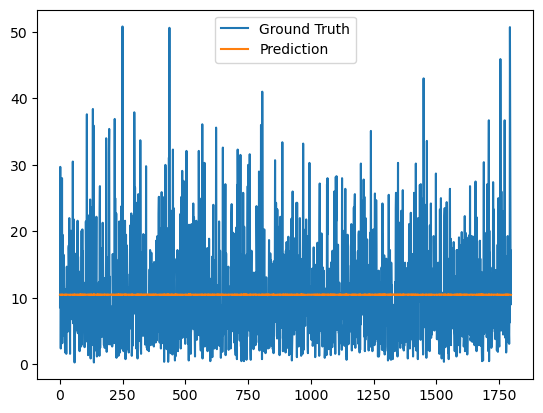

In [ ]:
pred, mode = pred_and_model
pred = scaler_c6h6.inverse_transform(np.array(pred).reshape(-1, 1)).flatten()
test_vec = scaler_c6h6.inverse_transform(y_test.to_numpy()[:len(pred)]).flatten()
print(f'MSE: {mean_squared_error(test_vec, pred)}')
print(f'MAE: {mean_absolute_error(test_vec, pred)}')
print(f'Correlation: {pearsonr(test_vec, pred)[0]}')
print(f'R2 Score: {r2_score(test_vec, pred)}')
plt.plot(test_vec, label="Ground Truth")
plt.plot(pred, label="Prediction")
plt.legend()
plt.show()
plt.close()


This was quite disappointing. I experimented with various hyperparameters, attempted to adjust the model, among other things, but there was no improvement. I would have loved to spend more time on it, but due to time constraints, I'm compelled to submit it as is.

### The correlation between various models through these plots.

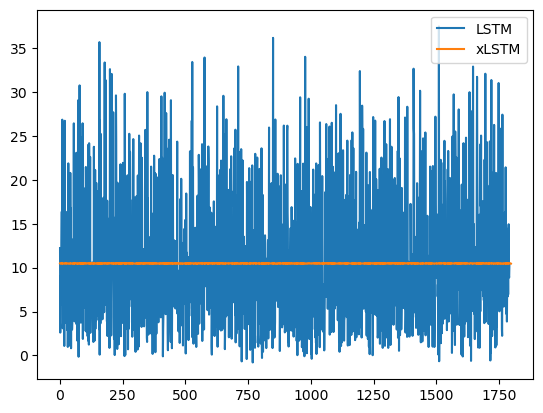

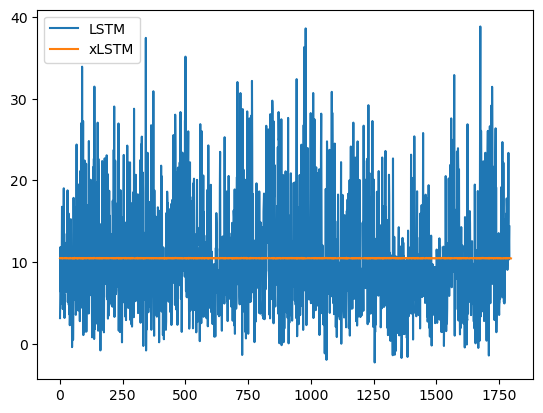

len of y_pred_plsm: 1792 --- len of pred: 1798
Correlation LSTM with xLSTM: -0.007128468383396244
Correlation PLSTM with xLSTM: 0.025711831582920987
Correlation LSTM with PLSTM: 0.0129739506840709


In [ ]:
plt.plot(y_pred_lsm, label="LSTM")
plt.plot(pred, label="xLSTM")
plt.legend()
plt.show()
plt.close()
plt.plot(y_pred_plsm, label="LSTM")
plt.plot(pred, label="xLSTM")
plt.legend()
plt.show()
plt.close()
print(f"len of y_pred_plsm: {len(y_pred_plsm)} --- len of pred: {len(pred)}")
print(f"Correlation LSTM with xLSTM: {pearsonr(y_pred_lsm, pred[:len(y_pred_lsm)])[0]}")
print(f"Correlation PLSTM with xLSTM: {pearsonr(y_pred_plsm, pred[:len(y_pred_plsm)])[0]}")
print(f"Correlation LSTM with PLSTM: {pearsonr(y_pred_lsm, y_pred_plsm)[0]}")

### LSTM to predicted the next value
Since I didn't achieve good results, I will experiment with the traditional LSTM to see how it performs.

In [ ]:
def train_model(model, data, val_data, epochs, seq_len, optimizer, criterion):
    # initialize the early_stopping object
    # loop through the epochs
    model.train()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
factor=0.1, patience=10, threshold=0.001, threshold_mode='abs')
    for epoch in range(epochs):
        # zero the gradients
        # initialize the loss
        test_all = 0
        # loop through the sequence length
        for t in range(seq_len - 1):
            # get the input at time t
            x = data[:, t]

            # get the target at time t+1
            y_true = data[:, t + 1, 0]
            # get the prediction
            y_pred = model(x)
            # calculate the loss from the training data
            loss = criterion(y_pred, y_true)
            test_all += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


        # validate the model on the validation data

        # print the validation loss


        val_loss = validate(model, val_data, criterion)

        scheduler.step(val_loss)
        print(f'Epoch {epoch} Validation Loss --- {val_loss}')



        # print the training loss every 10 epochs
        print(f'Epoch {epoch} Loss --- {test_all}')


# predict the model
def predict(model, data):
    # set the model to evaluation mode
    model.eval()
    # initialize the predictions
    predictions = []
    # loop through the sequence length
    with torch.no_grad():
        for t in range(data.shape[1] - 1):
            # get the input at time t
            x = data[:, t]
            # get the prediction
            y_pred = model(x)
            # append the prediction to the list
            predictions.append(y_pred.detach().numpy().ravel()[0])
        # set the model back to training mode
    model.train()
    # return the predictions
    return predictions

# validate the model with the validation data
def validate(model, data, criterion):
    # set the model to evaluation mode
    model.eval()
    # initialize the loss
    loss = 0
    # loop through the sequence length
    with torch.no_grad():
        for t in range(data.shape[1] - 1):
            # get the input at time t
            x = data[:, t]
            # get the target at time t+1
            y_true = data[:, t + 1, 0]
            # get the prediction
            y_pred = model(x)

            # calculate the loss from the validation data
            loss += criterion(y_pred, y_true)
    # set the model back to training mode
    model.train()
    # return the validation loss
    return loss

### Model creation

In [ ]:
class MyLSTM_UNI(nn.Module):
    def __init__(self, input_sz, hidden_sz, num_layers=1, output_sz_linear=1):
        super(MyLSTM_UNI, self).__init__()
        self.hidden_sz = hidden_sz
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_sz, hidden_size=hidden_sz, num_layers=num_layers)
        self.fc = nn.Linear(hidden_sz, output_sz_linear)
        # self.batchnorm = nn.BatchNorm1d(hidden_sz)
        # self.relu = nn.ReLU()


    def forward(self, values):
        h_0 = Variable(torch.zeros(self.num_layers, self.hidden_sz))
        c_0 = Variable(torch.zeros(self.num_layers, self.hidden_sz))
        lstm_out, _ = self.lstm(values, (h_0, c_0))
        # batch_out = self.batchnorm(lstm_out[:, -1, :])
        # relu_out = self.relu(batch_out)
        linear_out = self.fc(lstm_out)
        return linear_out[:,-1]

### Training

In [ ]:

model = MyLSTM_UNI(input_sz=1, hidden_sz=32, output_sz_linear=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
optimizer = torch.optim.Adam(model.parameters(),  lr=2e-4, weight_decay=1e-7)
train_model(model, uni_trainset, uni_evalset, 100, len(y_train), optimizer, criterion=F.smooth_l1_loss)


Epoch 0 Validation Loss --- 4.931011199951172
Epoch 0 Loss --- 45.85893878495596
Epoch 1 Validation Loss --- 4.918484687805176
Epoch 1 Loss --- 44.13297289933434
Epoch 2 Validation Loss --- 4.915341377258301
Epoch 2 Loss --- 44.10745388906055
Epoch 3 Validation Loss --- 4.914335250854492
Epoch 3 Loss --- 44.103281204794534
Epoch 4 Validation Loss --- 4.913873672485352
Epoch 4 Loss --- 44.10085373308651
Epoch 5 Validation Loss --- 4.9135847091674805
Epoch 5 Loss --- 44.098368250337764
Epoch 6 Validation Loss --- 4.913346290588379
Epoch 6 Loss --- 44.095834657816155
Epoch 7 Validation Loss --- 4.913141250610352
Epoch 7 Loss --- 44.093142803889236
Epoch 8 Validation Loss --- 4.912947177886963
Epoch 8 Loss --- 44.091177397891855
Epoch 9 Validation Loss --- 4.912826061248779
Epoch 9 Loss --- 44.08974421386138
Epoch 10 Validation Loss --- 4.912750720977783
Epoch 10 Loss --- 44.088804870385154
Epoch 11 Validation Loss --- 4.912679672241211
Epoch 11 Loss --- 44.08781629287241
Epoch 12 Validati

### Evaluation

MSE: 59.23103735049651
MAE: 5.914077520529606
Correlation: -0.9999616582741988
R2 Score: -0.03086977171084171


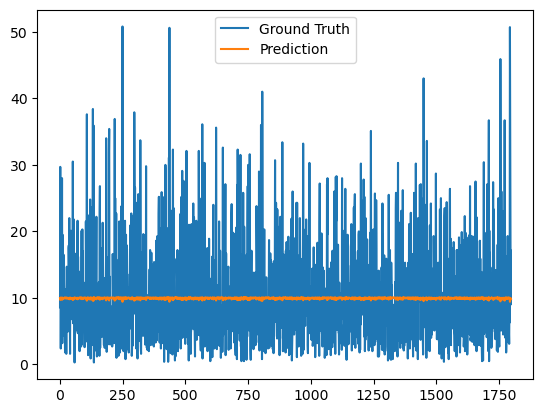

In [ ]:
uni_pred_lstm = predict(model, uni_testset)
uni_pred_lstm = scaler_c6h6.inverse_transform(np.array(uni_pred_lstm).reshape(-1, 1)).flatten()
test_vec = scaler_c6h6.inverse_transform(y_test.to_numpy()[:len(uni_pred_lstm)]).flatten()
print(f'MSE: {mean_squared_error(test_vec, uni_pred_lstm)}')
print(f'MAE: {mean_absolute_error(test_vec, uni_pred_lstm)}')
print(f'Correlation: {pearsonr(test_vec, uni_pred_lstm)[0]}')
print(f'R2 Score: {r2_score(test_vec, uni_pred_lstm)}')
plt.plot(test_vec, label="Ground Truth")
plt.plot(uni_pred_lstm, label="Prediction")
plt.legend()
plt.show()

It's the same story as with xLSTM.

## Final Consideration

The results are poor, but given the previously observed high correlation between the C6H6 column and PT08*, I find this surprising. However, since time is running out, I need to finish up.
I have three main hypotheses for why I got these results:

1. I made a significant but not obvious mistake to me in the definition of the models or data transformation.
2. The models cannot learn the patterns due to memory limitations.
3. I haven't found the right combination of layers and hyperparameters.


Future work could involve training the models on a small subset of the original dataset to see if they perform better. Additionally, trying different models like HMM or even a simple RNN for comparison could be beneficial. I feel disappointed because I expected to do a better job, but I have learned a lot, including about the new xLSTM model, which theoretically could be an alternative to transformers.